In [28]:
# Add directory above current directory to path
import sys as SYS; SYS.path.insert(0, '..')
import os

In [6]:
from src.random_hamiltonian import random_unitary
import matplotlib.pyplot as plt
import numpy as np
rng = np.random.default_rng()

from src import measurements as measure, density_matrix as DM

import time

In [7]:
def line_order(n):
    shift = rng.integers(n)
    return lambda:  np.roll(list(range(n)), shift)

def random_order(n):
    return lambda: rng.permutation(n)

def messenger_order_8():
    orders = [[0,1,2,3,4,5,6,7],[0,1,2,4,3,5,6,7]]
    return lambda: rng.choice(orders)

def messenger_order_12_type1_chunk_size_4():
    orders = [[0,1,2,3,4,5,6,7,8,9,10,11],[0,1,2,7,4,5,6,3,8,9,10,11],[0,1,2,3,4,5,6,11,8,9,10,7],[0,1,2,11,4,5,6,7,8,9,10,3]]
    return lambda: rng.choice(orders)

def messenger_order_12_type2_chunk_size_6():
    orders = [[0,1,2,3,4,5,6,7,8,9,10,11],[0,1,2,3,4,6,5,7,8,9,10,11]]
    return lambda: rng.choice(orders)

In [38]:
def run_n_trials(qm_sys: DM.DensityMatrix, num_blocks: int, measurment_set, num_trials: int, possible_orders):
    
    if type(measurment_set) != list:
        measurment_set = [measurment_set]
        
    
    
    start = time.time()
    N = qm_sys.number_of_qbits
    
    
    measurments = [np.array(measurment(qm_sys)) for measurment in measurment_set]

    assert N % num_blocks == 0, f"num_block = {num_blocks} must divide the size of the system {N}"
    block_size = N // num_blocks
    for i in range(num_trials):
        sub_system_unitaries = [random_unitary(block_size) for _ in range(num_blocks)]
        U = DM.tensor(sub_system_unitaries)

        # shift the order of the qbits

        order = possible_orders()

        U.relabel_basis(order)
        U.change_to_energy_basis()

        qm_sys = U * qm_sys * U.H

        
        measurments = [np.vstack((measurments[i], measurment(qm_sys)))  for i,measurment in enumerate(measurment_set)]
    print(f"{np.round(time.time() - start, 2)} seconds elapsed")
    return measurments

In [41]:
N = 4
num_blocks = 1
pops = [.1, .1, .1, .4]
my_sys = DM.n_thermal_qbits(pops)
my_sys.change_to_energy_basis()


In [54]:
results = run_n_trials(my_sys,num_blocks,[measure.pops,measure.extractable_work_of_each_qubit],5,random_order(4))

0.19 seconds elapsed


In [58]:
extractable_work = results[1]
pops = results[0]

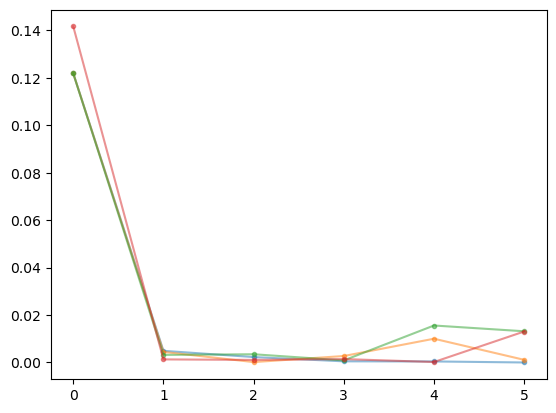

In [59]:
plt.plot(np.real(extractable_work),linestyle='-', marker='.',alpha = .5)
plt.show()

In [60]:
#this gets the change in work between each time step
change_in_work = extractable_work[1:]-extractable_work[:-1]

#this finds where the change in work is greater than zero (a larger cutoff can be used here to find more significant changes)
where_positive = change_in_work>0

#this gets where the change in work is positive for the ith qubit in time ordered manner
def change_in_work_Q_i(i):
    return change_in_work.real[0:,i]>0

#find the number of positive changes
num_positive_change = np.sum(where_positive)
print(num_positive_change)

#find the percent of positive changes
num_positive_change/(len(change_in_work)*N)

#find the number of positive changes across landscape for initially cold qubits
list_number_of_positive_for_initially_cold_qubits = [ sum(x) for x in zip(*where_positive)]
list_number_of_positive_for_initially_cold_qubits.pop(5)
print(list_number_of_positive_for_initially_cold_qubits)

#find the number of positive changes across landscape for initially hot qubits
print(sum(change_in_work_Q_i(5)))


6


IndexError: pop index out of range

In [27]:
intervals_length_for_Q_i(0)

[0,
 0,
 0,
 1,
 2,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 2,
 2,
 0,
 1,
 3,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 2,
 2]

In [26]:
#gives a list of intervals for each qubit i where change in work is positive
def intervals_length_for_Q_i(qubit):
    interval = [0]
    length = 0
    change_in_work_qubit = change_in_work_Q_i(qubit).tolist()
    change_in_work_qubit.append(0)
    for i in range(0,51):
        if change_in_work_qubit[i]==1:
            length = length +1
        else:
            interval.append(length)
            length = 0 
    return interval

In [29]:
#gives list of interval for which change in work is positive for the entire landscape
def all_intervals_on_landscape():
    all_intervals_on_landscape = []
    for i in range (0,N):
        all_intervals_on_landscape = all_intervals_on_landscape + intervals_length_for_Q_i(i)
    return all_intervals_on_landscape

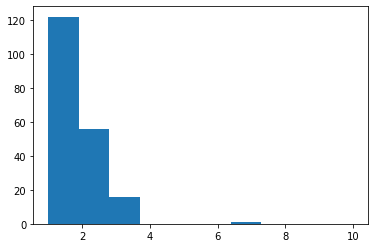

In [204]:
#plot histogram of interval lengths
plt.hist(all_intervals_on_landscape(),range=[1,10])
plt.show()

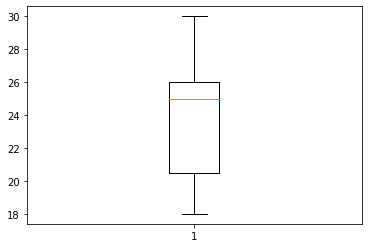

In [254]:
#creates boxplot for number of positive events for the initial hot vs cold qubit
plt.boxplot([list_number_of_positive_for_initially_cold_qubits])
plt.show()

In [75]:
def save_data(data:np.ndarray, num_qbits:str,measurment:str,num_chunks:str,connectivity_type:str,run_index:str,sim_index = int,extra = ""):
    index = 0
    if extra != "":
        path = f"../data/num_qbits={num_qbits}_num_chunks={num_chunks}_connectivity_type={connectivity_type}_other={extra}_index={sim_index}"
    else:
        path = f"../data/num_qbits={num_qbits}_num_chunks={num_chunks}_connectivity_type={connectivity_type}_index={sim_index}"
    if not os.path.exists(path):
        os.mkdir(path)
    file_name = path+f"/{measurment}_{run_index}.dat"
    np.savetxt(file_name,data,header=f"{measurment} for {num_qbits} qbits with connectivity {connectivity_type} in chunks {num_chunks}")

In [36]:
save_data(data = np.real(extractable_work),num_qbits = 12,measurment = "extractable_work",num_chunks = 2,connectivity_type = "messenger_qbit",run_index = 0)

In [76]:
N = 12
num_chunks = 3
for index in range(20):
    print(f"working on the {index}th run")
    pops = [.2 for _ in range(12)]
    pops[5] = .4
    
    my_sys = DM.n_thermal_qbits(pops)
    my_sys.change_to_energy_basis()
    results = run_n_trials(my_sys,num_chunks,[measure.pops,measure.extractable_work_of_each_qubit],100,line_order(N))
    save_data(results[0], N, "pops" ,num_chunks,"line",index,0)
    save_data(results[1], N, "extractable_work",num_chunks,"line",index,0)

working on the 0th run
12.08 seconds elapsed
working on the 1th run
11.88 seconds elapsed
working on the 2th run
11.85 seconds elapsed
